# Neural Style: Neural Style in Pytorch!
An implementation of the neural style in PyTorch! This notebook implements [Image Style Transfer Using Convolutional Neural Networks](https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Gatys_Image_Style_Transfer_CVPR_2016_paper.pdf) by Leon Gatys, Alexander Ecker, and Matthias Bethge. 

This implementation is inspired by the implementations of:
* Anish Athalye [Neural Style in Tensorflow](https://github.com/anishathalye/neural-style),
* Justin Johnson [Neural Style in Torch](https://github.com/jcjohnson/neural-style), and
* ProGamerGov [Neural Style in PyTorch](https://github.com/ProGamerGov/neural-style-pt)

The [original caffe pretrained weights of VGG19](https://github.com/jcjohnson/pytorch-vgg) were used for this implementation, instead of the pretrained VGG19's in PyTorch's model zoo.

### Example Style Transfer

<img src='images/janelle_transfer_preserve.png' width='100%' />



<center>Janelle Monae</center>

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# import os
# path="/content/drive/MyDrive/COMP9444/neural-style-pytorch-master"
# os.chdir(path)
# os.listdir(path)

In [1]:
#Uncomment this block to download the model file - GOOGLE COLAB

# Download VGG19 Model
!wget -c https://web.eecs.umich.edu/~justincj/models/vgg19-d01eb7cb.pth
!mkdir models
!cp vgg19-d01eb7cb.pth models/

# Download Images
!wget -c https://github.com/iamRusty/neural-style-pytorch/archive/master.zip
!unzip -q master.zip
!mkdir images
!cp neural-style-pytorch-master/images/1-content.png images
!cp neural-style-pytorch-master/images/1-style.jpg images

print("Hello World!")

--2022-07-24 05:26:40--  https://web.eecs.umich.edu/~justincj/models/vgg19-d01eb7cb.pth
Resolving web.eecs.umich.edu (web.eecs.umich.edu)... 141.212.113.214
Connecting to web.eecs.umich.edu (web.eecs.umich.edu)|141.212.113.214|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 574689280 (548M) [application/x-tar]
Saving to: ‘vgg19-d01eb7cb.pth’

vgg19-d01eb7cb.pth  100%[===================>] 548.07M  84.0MB/s    in 6.7s    

2022-07-24 05:26:47 (81.5 MB/s) - ‘vgg19-d01eb7cb.pth’ saved [574689280/574689280]

--2022-07-24 05:26:50--  https://github.com/iamRusty/neural-style-pytorch/archive/master.zip
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://github.com/rrmina/neural-style-pytorch/archive/master.zip [following]
--2022-07-24 05:26:50--  https://github.com/rrmina/neural-style-pytorch/archive/master.zip
Reusing ex

In [2]:
# Import!
import torch
import torch.nn as nn
import torch.optim as optim

import copy
import numpy as np
import matplotlib.pyplot as plt
from torchvision import models, transforms

import cv2
import copy
from PIL import Image

In [60]:
# Hyperparameters
MAX_IMAGE_SIZE = 512

# Optimizer
OPTIMIZER = 'lbfgs' #or 'adam'
ADAM_LR = 10
CONTENT_WEIGHT = 5e0
STYLE_WEIGHT = 1e2
TV_WEIGHT = 1e-3
NUM_ITER = 500
SHOW_ITER = 100

# Image Files
INIT_IMAGE = 'random' # or 'content'
PRESERVE_COLOR = 'True' # 'False'
PIXEL_CLIP = 'True' # or 'False' - Clipping produces better images
CONTENT_PATH = 'images/1-content.png'
STYLE_PATH = 'images/1-style.jpg'
COLOR_PATH = 'images/color.png'

"""
PRETRAINED VGG MODELS 
GITHUB REPO: https://github.com/jcjohnson/pytorch-vgg
VGG 19: https://web.eecs.umich.edu/~justincj/models/vgg19-d01eb7cb.pth
VGG 16: https://web.eecs.umich.edu/~justincj/models/vgg16-00b39a1b.pth
"""
VGG19_PATH = 'models/vgg19-d01eb7cb.pth'
POOL = 'max'

In [61]:
# Print the device
device = ("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [62]:
# Utils
# Load image file
def load_image(path):
    # Images loaded as BGR
    img = cv2.imread(path)
    return img

# Show image
def show(img):
    # Convert from BGR to RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # imshow() only accepts float [0,1] or int [0,255]
    img = np.array(img/255).clip(0,1)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(img)
    plt.show()
    
# Save Image as out{num_iterms}.png
def saveimg(img, iters):
    if (PIXEL_CLIP=='True'):
        img = img.clip(0, 255)
    cv2.imwrite('out'+str(iters)+'.png', img)
    
# Color transfer
def transfer_color(src, dest):
    if (PIXEL_CLIP=='True'):
        src, dest = src.clip(0,255), dest.clip(0,255)
        
    # Resize src to dest's size
    H,W,_ = src.shape 
    dest = cv2.resize(dest, dsize=(W, H), interpolation=cv2.INTER_CUBIC)
    
    dest_gray = cv2.cvtColor(dest, cv2.COLOR_BGR2GRAY) #1 Extract the Destination's luminance
    src_yiq = cv2.cvtColor(src, cv2.COLOR_BGR2YCrCb)   #2 Convert the Source from BGR to YIQ/YCbCr
    src_yiq[...,0] = dest_gray                         #3 Combine Destination's luminance and Source's IQ/CbCr
    
    return cv2.cvtColor(src_yiq, cv2.COLOR_YCrCb2BGR)  #4 Convert new image from YIQ back to BGR

In [64]:
# Preprocessing
def itot(img):
    # Rescale the image
    H, W, C = img.shape
    image_size = tuple([int((float(MAX_IMAGE_SIZE) / max([H,W]))*x) for x in [H, W]])
    
    itot_t = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(image_size),
        transforms.ToTensor()
    ])
    
    # Subtract the means
    normalize_t = transforms.Normalize([103.939, 116.779, 123.68],[1,1,1])
    tensor = normalize_t(itot_t(img)*255)
    
    # Add the batch_size dimension
    tensor = tensor.unsqueeze(dim=0)
    return tensor

def ttoi(tensor):
    # Add the means
    ttoi_t = transforms.Compose([
        transforms.Normalize([-103.939, -116.779, -123.68],[1,1,1])])
    
    # Remove the batch_size dimension
    tensor = tensor.squeeze()
    img = ttoi_t(tensor)
    img = img.cpu().numpy()
    
    # Transpose from [C, H, W] -> [H, W, C]
    img = img.transpose(1, 2, 0)
    return img

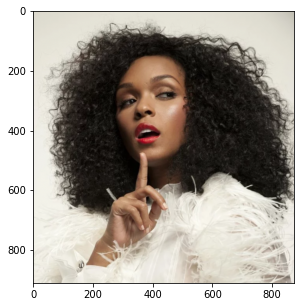

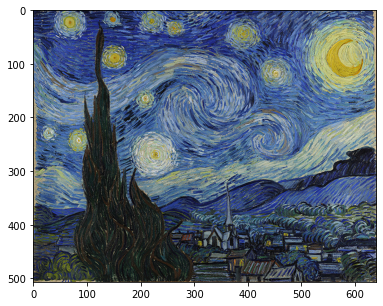

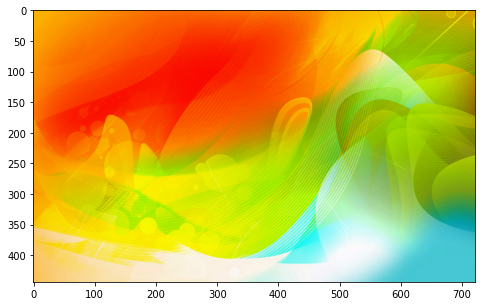

In [65]:
# Load Images
content_img = load_image(CONTENT_PATH)
style_img = load_image(STYLE_PATH)   
color_img = load_image(COLOR_PATH) 

# Show Images
show(content_img)
show(style_img)
show(color_img)

In [66]:
# Load VGG19 Skeleton
vgg = models.vgg19(pretrained=False)

# Load pretrained weights
vgg.load_state_dict(torch.load(VGG19_PATH), strict=False)

# Change Pooling Layer
def pool_(model, pool='avg'):
    if (pool=='avg'):
        ct=0
        for layer in model.children():
            if isinstance(layer, nn.MaxPool2d):
                model[ct] = nn.AvgPool2d(kernel_size=2, stride=2, padding=0, ceil_mode=False)
            ct+=1
    elif (pool=='max'):
        ct=0
        for layer in model.children():
            if isinstance(layer, nn.AvgPool2d):
                model[ct] = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
            ct+=1
            
    return model

#vgg.features = pool_(vgg.features, POOL)

# Extract only the 'features' network, 
# 'classifier' network is not needed
model = copy.deepcopy(vgg.features)
model.to(device)

# Turn-off unnecessary gradient tracking
for param in model.parameters():
    param.requires_grad = False

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [67]:
"""
Loss Functions
All loss functions are basically Mean of the Squared Errors (MSE)
g - generated features
c - content features
s - style features

1. What is Total Variation(TV) Loss ???
    The total variation (TV) loss encourages spatial smoothness in the generated image. 
   It was not used by Gatys et al in their CVPR paper but it can sometimes improve the 
   results; for more details and explanation see Mahendran and Vedaldi 
   "Understanding Deep Image Representations by Inverting Them" CVPR 2015.

   - @jcjohnson
   https://github.com/jcjohnson/neural-style/issues/302

2. How to implement TV Loss?
    https://en.wikipedia.org/wiki/Total_variation_denoising
"""
mse_loss = torch.nn.MSELoss()
def gram(tensor):
    B, C, H, W = tensor.shape
    x = tensor.view(C, H*W)
    return torch.mm(x, x.t())

def content_loss(g, c):
    loss = mse_loss(g, c)
    return loss
    
def style_loss(g, s):
    c1,c2 = g.shape
    loss = mse_loss(g, s)
    return loss / (c1**2) # Divide by square of channels

def tv_loss(c):
    x = c[:,:,1:,:] - c[:,:,:-1,:]
    y = c[:,:,:,1:] - c[:,:,:,:-1]
    loss = torch.sum(torch.abs(x)) + torch.sum(torch.abs(y))
    return loss

In [68]:
# VGG Forward Pass
def get_features(model, tensor):
    layers = {
        '3': 'relu1_2',   # Style layers
        '8': 'relu2_2',
        '17' : 'relu3_3',
        '26' : 'relu4_3',
        '35' : 'relu5_3',
        '22' : 'relu4_2', # Content layers
        #'31' : 'relu5_2'
    }
    
    # Get features
    features = {}
    x = tensor
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            if (name=='22'):   # relu4_2
                features[layers[name]] = x
            elif (name=='31'): # relu5_2
                features[layers[name]] = x
            else:
                b, c, h, w = x.shape
                features[layers[name]] = gram(x) / (h*w)
                
            # Terminate forward pass
            if (name == '35'):
                break
            
    return features

In [69]:
# Generate Initial Image
def initial(content_tensor, init_image='random'):
    B, C, H, W = content_tensor.shape
    if (init_image=='random'):
        #tensor = torch.randn(C, H, W).mul(torch.std(content_tensor.clone().cpu())/255).unsqueeze(0)
        tensor = torch.randn(C, H, W).mul(0.001).unsqueeze(0)
    else:
        tensor = content_tensor.clone().detach()
    
    return tensor


In [70]:
"""
Define Optimizer
The optimizer minimizes the total loss by updating the tensor 'x'.
"""
def chose_optim(OPTIMIZER, x):
  if (OPTIMIZER=='lbfgs'):
      optimizer = optim.LBFGS([x])
  elif (OPTIMIZER=='adam'):
      optimizer = optim.Adam([x], lr=ADAM_LR)
  return optimizer

In [71]:
from matplotlib.artist import kwdoc
def stylize(c_tensor,s_tensor,k, iteration=NUM_ITER):     
    # Get features representations/Forward pass
    content_layers = ['relu4_2']
    content_weights = {'relu4_2': 1.0} 
    style_layers = ['relu1_2', 'relu2_2', 'relu3_3', 'relu4_3', 'relu5_3']
    style_weights = {'relu1_2': 0.2, 'relu2_2': 0.2, 'relu3_3': 0.2, 'relu4_3': 0.2, 'relu5_3': 0.2}
    c_feat = get_features(model, c_tensor)
    s_feat = get_features(model, s_tensor)
    optimizer = chose_optim(OPTIMIZER,k)
    
    i = [0]
    while i[0] < iteration:
        def closure():
            # Zero-out gradients
            optimizer.zero_grad()

            # Forward pass
            g_feat = get_features(model, k)

            # Compute Losses
            c_loss=0
            s_loss=0
            for j in content_layers:
                c_loss += content_weights[j] * content_loss(g_feat[j], c_feat[j])
            for j in style_layers:
                s_loss += style_weights[j] * style_loss(g_feat[j], s_feat[j])
            
            c_loss = CONTENT_WEIGHT * c_loss
            s_loss = STYLE_WEIGHT * s_loss
            t_loss = TV_WEIGHT * tv_loss(k.clone().detach())
            total_loss = c_loss + s_loss + t_loss

            # Backprop
            total_loss.backward(retain_graph=True)
            
            # Print Loss, show and save image
            i[0]+=1
            if (((i[0] % SHOW_ITER) == 1) or (i[0]==NUM_ITER)):
                print("Style Loss: {} Content Loss: {} TV Loss: {} Total Loss : {}".format(s_loss.item(), c_loss.item(), t_loss, total_loss.item()))
                if (PRESERVE_COLOR=='True'):
                    g_ = transfer_color(ttoi(c_tensor.clone().detach()), ttoi(k.clone().detach()))
                else:
                    g_ = ttoi(k.clone().detach())
                show(g_)
                saveimg(g_, i[0]-1)
                plt.show()
            
            return (total_loss)
        
        # Weight/Pixel update
        optimizer.step(closure)

    return k

In [72]:
# Convert Images to Tensor
content_tensor = itot(content_img).to(device)
color_tensor = itot(color_img).to(device)
style_tensor = itot(style_img).to(device)
g = initial(content_tensor, init_image=INIT_IMAGE)
g = g.to(device).requires_grad_(True)
color = initial(color_tensor, init_image=INIT_IMAGE)
color = color.to(device).requires_grad_(True)

In [56]:
# color_clone = ttoi(color_tensor.clone().detach())
# style_clone = ttoi(style_tensor.clone().detach())
# new_style = transfer_color(color_clone,style_clone)
# show(new_style)

In [58]:
# new = itot(new_style).to(device)
# out = stylize(content_tensor,new,g,iteration=NUM_ITER)

Style Loss: 63067464.0 Content Loss: 1737912.75 TV Loss: 1.085166335105896 Total Loss : 64805376.0


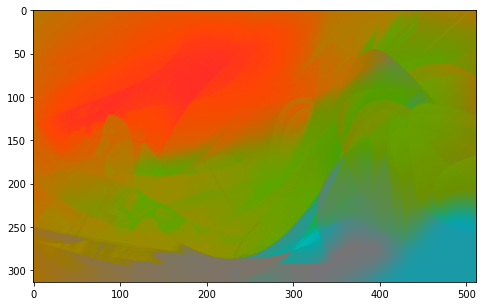

Style Loss: 260594.71875 Content Loss: 1300422.0 TV Loss: 13297.16796875 Total Loss : 1574313.875


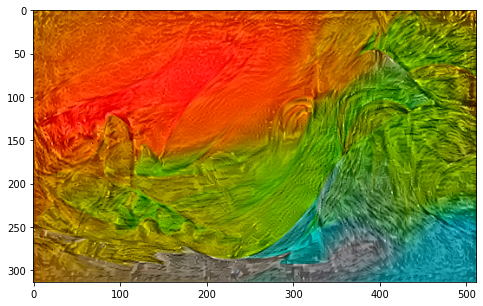

Style Loss: 131927.484375 Content Loss: 1091159.375 TV Loss: 14184.548828125 Total Loss : 1237271.375


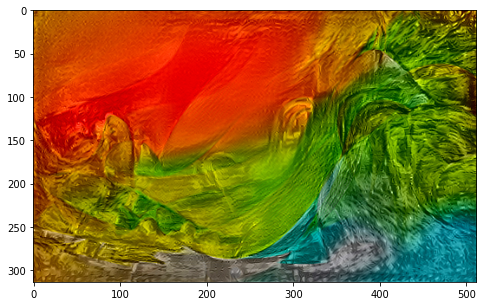

Style Loss: 112031.2265625 Content Loss: 1022631.875 TV Loss: 15094.771484375 Total Loss : 1149757.875


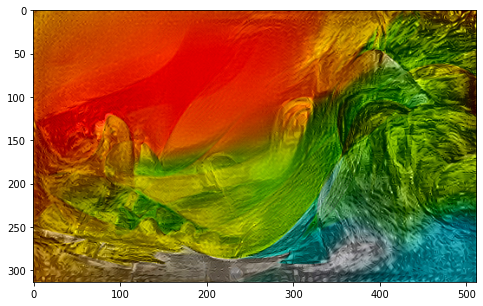

Style Loss: 103287.375 Content Loss: 989212.25 TV Loss: 16422.265625 Total Loss : 1108921.875


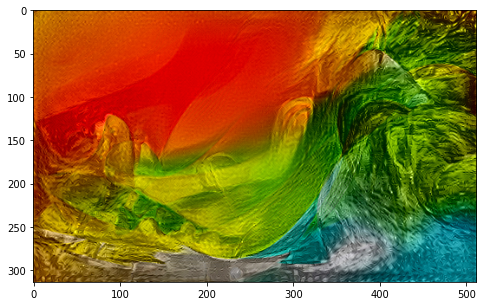

Style Loss: 101476.796875 Content Loss: 971238.125 TV Loss: 17446.59765625 Total Loss : 1090161.5


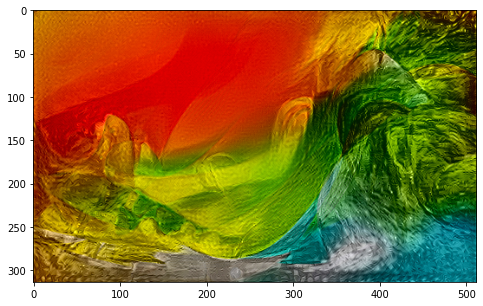

Style Loss: 101397.4296875 Content Loss: 971181.5 TV Loss: 17459.994140625 Total Loss : 1090038.875


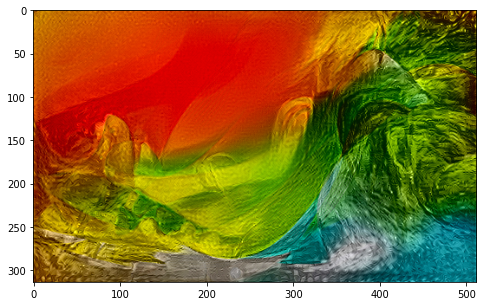

In [73]:
out_color = stylize(color_tensor,style_tensor,color,iteration=NUM_ITER)
# final = initial(out_content, init_image=INIT_IMAGE)
# final = final.to(device).requires_grad_(True)

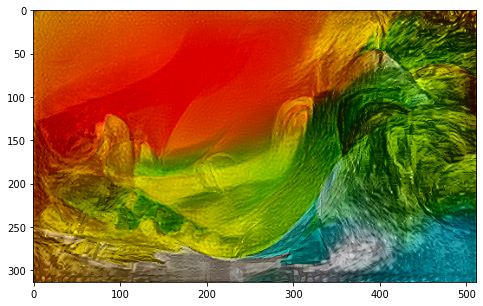

In [74]:
if (PRESERVE_COLOR=='True'):
    c_clone = ttoi(color_tensor.clone().detach())
    color_clone = ttoi(color.clone().detach())
    g_preserve = transfer_color(c_clone, color_clone) # Style Transfer + Preserve original color
    show(g_preserve)
    saveimg(g_preserve, 333) # out333 = final with preseved colors

Style Loss: 62570332.0 Content Loss: 1237537.75 TV Loss: 1.694986343383789 Total Loss : 63807868.0


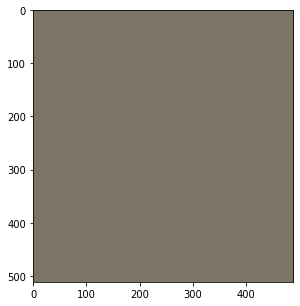

Style Loss: 216069.625 Content Loss: 820225.5625 TV Loss: 21536.466796875 Total Loss : 1057831.625


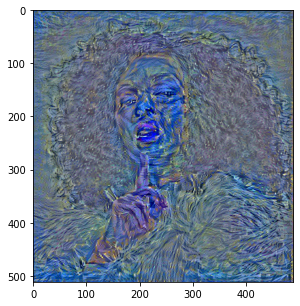

Style Loss: 86001.1953125 Content Loss: 592473.4375 TV Loss: 23366.40625 Total Loss : 701841.0


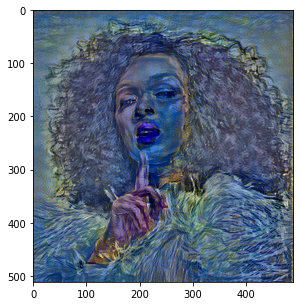

Style Loss: 62177.11328125 Content Loss: 520864.5 TV Loss: 24650.814453125 Total Loss : 607692.4375


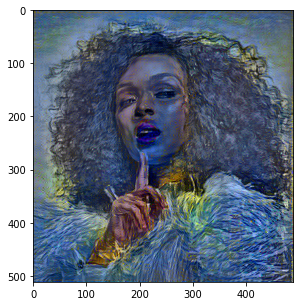

Style Loss: 58529.375 Content Loss: 486904.71875 TV Loss: 25927.93359375 Total Loss : 571362.0625


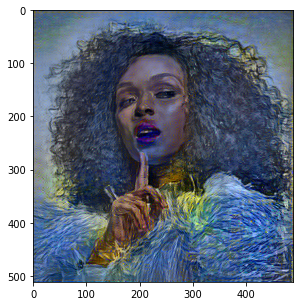

Style Loss: 58556.3046875 Content Loss: 471354.0 TV Loss: 27136.671875 Total Loss : 557047.0


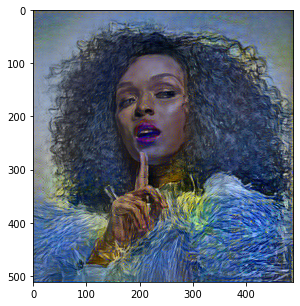

Style Loss: 58622.72265625 Content Loss: 471171.40625 TV Loss: 27143.31640625 Total Loss : 556937.4375


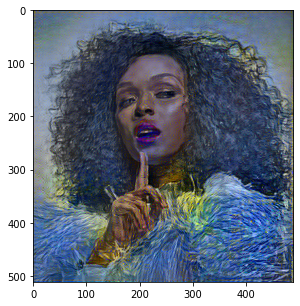

In [75]:
PRESERVE_COLOR = 'False'
out_content = stylize(content_tensor,out_color,g,iteration=NUM_ITER)
PRESERVE_COLOR = 'True'

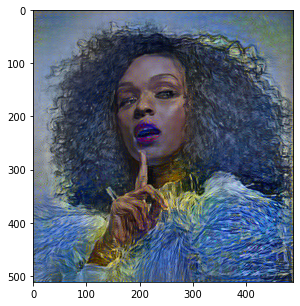

In [48]:
show(ttoi(out_content.clone().detach())) # Style Transfer

Style Loss: 63067564.0 Content Loss: 1237537.75 TV Loss: 1.6940441131591797 Total Loss : 64305100.0


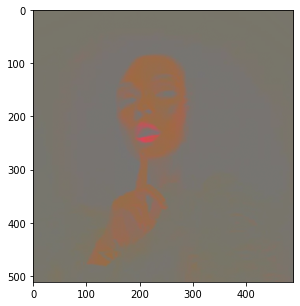

Style Loss: 254031.171875 Content Loss: 872095.25 TV Loss: 21164.765625 Total Loss : 1147291.125


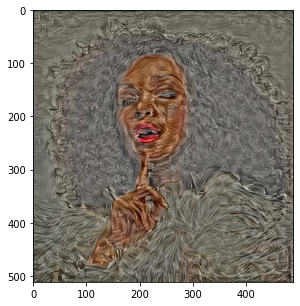

Style Loss: 110578.125 Content Loss: 634915.5 TV Loss: 22922.634765625 Total Loss : 768416.25


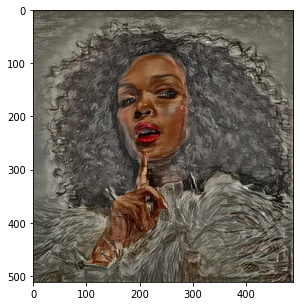

Style Loss: 82365.34375 Content Loss: 564008.3125 TV Loss: 24064.73828125 Total Loss : 670438.375


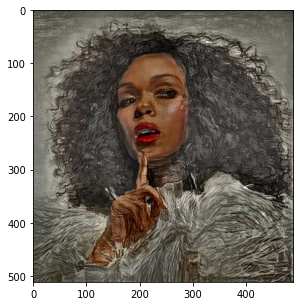

Style Loss: 77714.7578125 Content Loss: 529778.75 TV Loss: 25171.484375 Total Loss : 632665.0


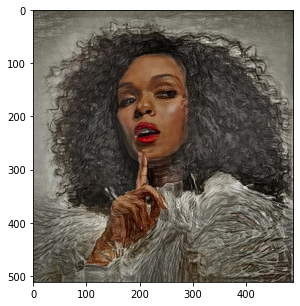

Style Loss: 77508.0625 Content Loss: 514206.90625 TV Loss: 26319.421875 Total Loss : 618034.4375


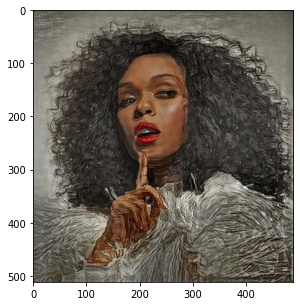

Style Loss: 77461.6328125 Content Loss: 514135.625 TV Loss: 26335.529296875 Total Loss : 617932.75


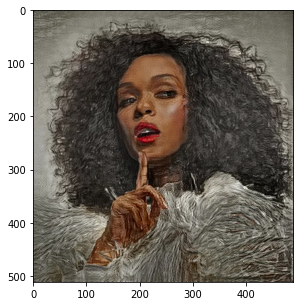

In [43]:
# Stylize!
# PRESERVE_COLOR = 'False'
out_content = stylize(content_tensor,style_tensor,g,iteration=NUM_ITER)
# PRESERVE_COLOR = 'True'

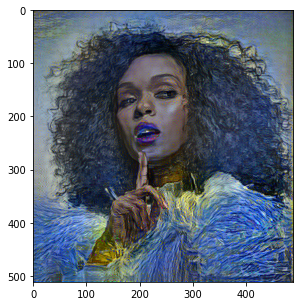

In [44]:
show(ttoi(out_content.clone().detach())) # Style Transfer

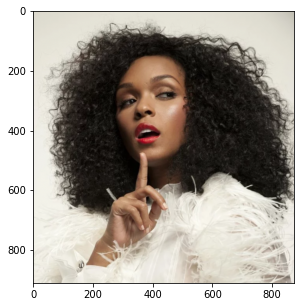

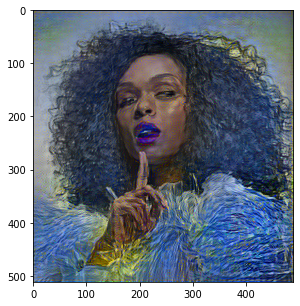

In [24]:
show(content_img) # Original Content

show(ttoi(g.clone().detach())) # Style Transfer
# show(ttoi(final.clone().detach())) # Final Transfer
saveimg(ttoi(g.clone().detach()), NUM_ITER)

if (PRESERVE_COLOR=='True'):
    c_clone = ttoi(content_tensor.clone().detach())
    g_clone = ttoi(g.clone().detach())
    g_preserve = transfer_color(c_clone, g_clone) # Style Transfer + Preserve original color
    show(g_preserve)
    saveimg(g_preserve, 333) # out333 = final with preseved colors